# Code associated with the AMD FAIR Datasets work

## Import librairies

In [1]:
import os
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

sns.set(
    font="Calibri",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": True,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 14, "axes.titlesize": 14, "axes.labelsize": 14}
)

## General functions

In [2]:
def get_column_values(dataframe, column_name):
    """
    Get all values from a specified column in a DataFrame as a list.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to extract values from.
    column_name (str): The name of the column to extract values from.

    Returns:
    list or None: The values from the specified column as a list or None if the column does not exist.
    """
    if column_name in dataframe.columns:
        # return dataframe[column_name].tolist()
        return dataframe[column_name].astype(str).str.lower().tolist()
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return None


def get_unique_counts(input_list):
    unique_counts = {}
    for item in input_list:
        if item in unique_counts:
            unique_counts[item] += 1
        else:
            unique_counts[item] = 1
    return unique_counts

## Analysis of dataset search results

### Data file specs

In [3]:
datafilename = "dataset-search-results.xlsx"
datafilepath = os.path.join("input", "dataset", "primary", datafilename)

### Search results

In [4]:
search_results_sheets = [
    "googleDatasetsResults",
    "datasetCatalogResults",
    "pubmedDatasetsResults",
]
for sheet_name in search_results_sheets:
    df = pd.read_excel(datafilepath, sheet_name=sheet_name)

    column_name = "meetInclusionCriteria"
    column_values = get_column_values(df, column_name)
    unique_counts = get_unique_counts(column_values)
    list_links = list(df[column_name])
    # list_links = get_column_values(df, "datasetDOIOrLink")
    print("--------------------")
    print(sheet_name)
    print("Retuned a total of ", len(list_links), " datasets")
    print("")
    print("meet all criteria:")
    print(unique_counts)

    criteria = ["isAMDrelated", "hasOCTdata", "isOpenlyAccessible"]
    for criterion in criteria:
        column_values = list(df[criterion])
        # column_values = get_column_values(df, criterion)
        unique_counts = get_unique_counts(column_values)
        print(f"{criterion}:")
        print(unique_counts)
    print("")

--------------------
googleDatasetsResults
Retuned a total of  42  datasets

meet all criteria:
{'yes': 9, 'no': 26, 'na': 7}
isAMDrelated:
{'yes': 29, 'na': 12, 'no': 1}
hasOCTdata:
{'yes': 16, 'no': 14, 'na': 12}
isOpenlyAccessible:
{'yes': 25, 'no': 5, 'na': 12}

--------------------
datasetCatalogResults
Retuned a total of  142  datasets

meet all criteria:
{'no': 141, 'yes': 1}
isAMDrelated:
{nan: 130, 'no': 9, 'yes': 3}
hasOCTdata:
{nan: 130, 'yes': 10, 'no': 2}
isOpenlyAccessible:
{nan: 130, 'yes': 10, 'no': 2}

--------------------
pubmedDatasetsResults
Retuned a total of  15  datasets

meet all criteria:
{'yes': 12, 'no': 3}
isAMDrelated:
{'yes': 15}
hasOCTdata:
{'yes': 12, 'no': 3}
isOpenlyAccessible:
{'yes': 15}



## Dataset FAIRness evaluation

### Required functions

In [5]:
def find_duplicates(input_list):
    seen = set()
    duplicates = set()
    for item in input_list:
        if item in seen:
            duplicates.add(item)
        else:
            seen.add(item)
    return list(duplicates)


def remove_duplicates(input_list):
    seen = set()
    result = []
    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

### Import data

In [6]:
datafilename = "dataset-evaluation-results.xlsx"
datafilepath = os.path.join("input", "dataset", "primary", datafilename)
sheet_name = "evaluation"
df = pd.read_excel(datafilepath, sheet_name)
df = df.iloc[::2]  # remove the comments rows
df = df.reset_index(drop=True)
df["yearPublished"] = df["yearPublished"].astype(
    "Int64"
)  # to interpret year as integer
df = df.sort_values("yearPublished").reset_index(drop=True)


# Compliance matrix for analysis per principle
df_compliance_matrix = pd.read_excel(datafilepath, sheet_name="complianceMatrix")

### Preliminary analysis 

In [7]:
number_datasets = len(df.index)

print(
    f"We identified {number_datasets} unique datasets that are relevant to this study"
)

# Dataset publication years
year_list = list(df["yearPublished"])
year_min = min(year_list)
year_max = max(year_list)
print("The earliest dataset was published in", str(year_min))
print("The latest dataset was published in", str(year_max))

# Dataframe with datset published before 2019 only and from 2019
m = df["yearPublished"].gt(2018)
idxmax = m.idxmax()
df_pre2019 = df.loc[: idxmax - 1].reset_index(drop=True)
df_from2019 = df.loc[idxmax:].reset_index(drop=True)
number_datasets_pre2019 = len(df_pre2019.index)
number_datasets_from2019 = len(df_from2019.index)
print(
    f"{number_datasets_pre2019} were published before 2019 and {number_datasets_from2019} in 2019 or later"
)

We identified 16 unique datasets that are relevant to this study
The earliest dataset was published in 2012
The latest dataset was published in 2024
9 were published before 2019 and 7 in 2019 or later


In [8]:
# How datasets are shared
column_values = list(df["wherePublished"])
unique_counts = get_unique_counts(column_values)
print(
    "Datasets retained in this study are published/shared at the following locations:"
)
print(unique_counts)

column_values = list(df_pre2019["wherePublished"])
unique_counts = get_unique_counts(column_values)
print("Datasets published before 2019 were published at the following locations:")
print(unique_counts)

column_values = list(df_from2019["wherePublished"])
unique_counts = get_unique_counts(column_values)
print("Datasets published frpm 2019 were published at the following locations:")
print(unique_counts)

Datasets retained in this study are published/shared at the following locations:
{'Custom website': 6, 'Borealis': 1, 'Karger': 1, 'Mendeley Data': 8}
Datasets published before 2019 were published at the following locations:
{'Custom website': 6, 'Borealis': 1, 'Karger': 1, 'Mendeley Data': 1}
Datasets published frpm 2019 were published at the following locations:
{'Mendeley Data': 7}


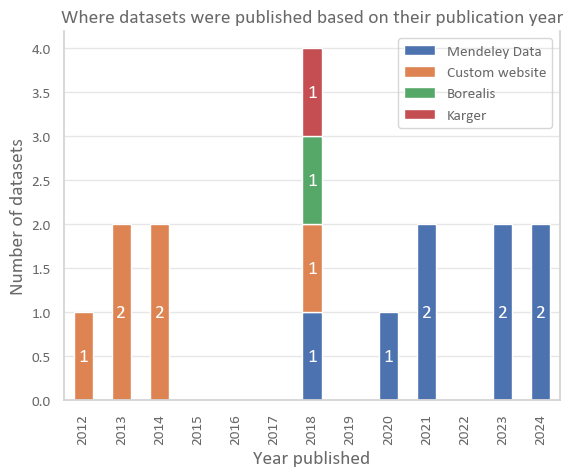

In [9]:
# How datasets have been shared over the years
years = list(range(year_min, year_max + 1))
locations = list(set(df["wherePublished"]))
columns = ["Year published"] + locations
df_where_published_year = pd.DataFrame(columns=columns)
df_where_published_year["Year published"] = years
ind = -1
for year in years:
    ind += 1
    for location in locations:
        count = len(
            df[(df["yearPublished"] == year) & (df["wherePublished"] == location)]
        )
        df_where_published_year.loc[ind, location] = count

ax = df_where_published_year.plot(
    x="Year published",
    kind="bar",
    stacked=True,
    ylabel="Number of datasets",
    title="Where datasets were published based on their publication year",
)

ax.grid(axis="y", color="0.9")
ax.set_axisbelow(True)

for c in ax.containers:
    ax.bar_label(
        c, fmt=lambda x: int(x) if x > 0 else "", label_type="center", color="white"
    )

plt.show()

### Overall compliance with the FAIR Principles

In [10]:
# Compliance per dataset with each of the FAIR Principles
for index in df_compliance_matrix.index:
    principle = df_compliance_matrix.loc[index, "principle"]
    df_principle = df_compliance_matrix.loc[[index]].dropna(axis=1, how="all")
    columns = list(df_principle.columns)
    columns.remove("principle")
    df[principle] = np.nan
    for index_main in df.index:
        no_count = 0
        for column in columns:
            if df.loc[index_main, column] == "no":
                no_count += 1
        if no_count > 0:
            df.loc[index_main, principle] = "Not compliant"
        else:
            df.loc[index_main, principle] = "Compliant"

In [11]:
# Full, partial, vs no compliance with FAIR principles and number of Principles complied with
principle_list = list(df_compliance_matrix["principle"])
number_principle = len(principle_list)
is_fair_column = "isFAIR"
number_fulfilled_column = "Number of Principles fulfilled"
df[is_fair_column] = np.nan
df[number_fulfilled_column] = np.nan
for index_main in df.index:
    not_compliant_count = 0
    compliant_count = 0
    for principle in principle_list:
        if df.loc[index_main, principle] == "Not compliant":
            not_compliant_count += 1
        else:
            compliant_count += 1
    if not_compliant_count == 0:
        df.loc[index_main, is_fair_column] = "yes"
    elif not_compliant_count == number_principle:
        df.loc[index_main, is_fair_column] = "no"
    else:
        df.loc[index_main, is_fair_column] = "partially"
    df.loc[index_main, number_fulfilled_column] = compliant_count

df[number_fulfilled_column] = df[number_fulfilled_column].astype("Int64")

column_values = list(df[is_fair_column])
unique_counts = get_unique_counts(column_values)
print(is_fair_column)
print(unique_counts)

isFAIR
{'partially': 16}


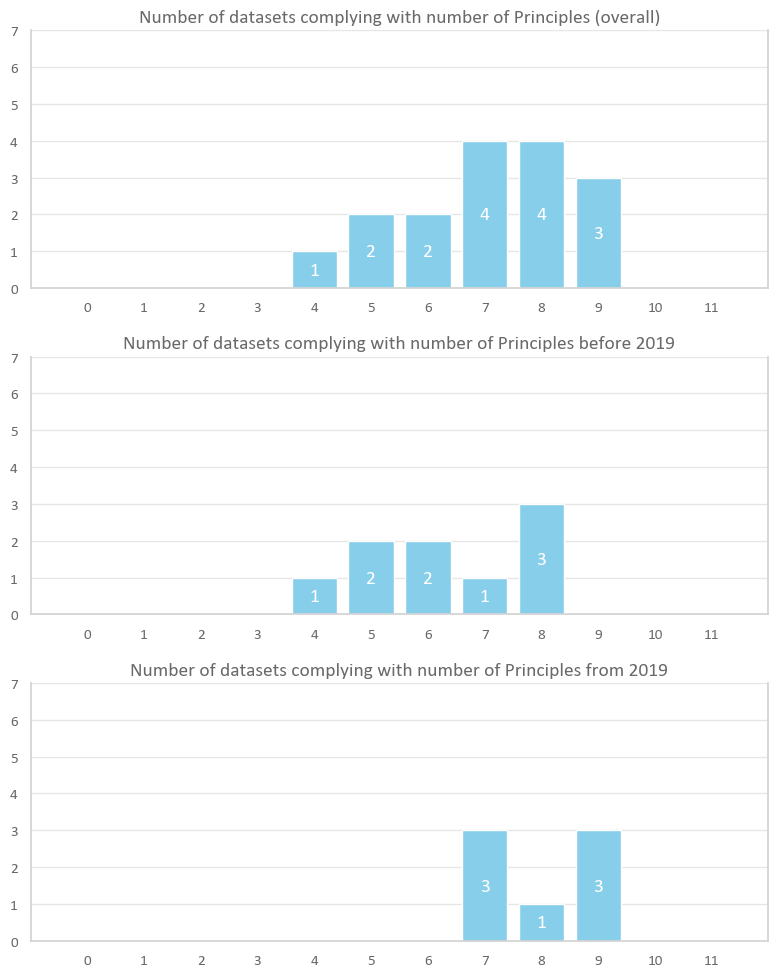

In [12]:
# Number of Principles fulfilled
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

df_pre2019 = df.loc[: idxmax - 1].reset_index(drop=True)
df_from2019 = df.loc[idxmax:].reset_index(drop=True)

df_lists = [df, df_pre2019, df_from2019]
compliant_counts = list(range(0, len(principle_list) + 1))

title_suffixes = [" (overall)", " before 2019", " from 2019"]
for idx, df_c in enumerate(df_lists):
    number_compliant_with_count = []
    for compliant_count in compliant_counts:
        try:
            number_compliant_with_count.append(
                df_c[number_fulfilled_column].value_counts()[compliant_count]
            )
        except:
            number_compliant_with_count.append(0)
    ax = axs[idx]
    ax.bar(compliant_counts, number_compliant_with_count, color="skyblue")
    ax.set_xlabel = "Number of Principles fulfilled"
    ax.set_ylabel = "Number of datasets"

    ax.set_title(
        "Number of datasets complying with number of Principles" + title_suffixes[idx]
    )
    # ax.xaxis.set_label("Number of Principles fulfilled")
    ax.xaxis.set_ticks(compliant_counts)
    ax.yaxis.set_ticks(list(range(0, 8)))
    ax.grid(axis="y", color="0.9")
    ax.set_axisbelow(True)

    for c in ax.containers:
        ax.bar_label(
            c, fmt=lambda x: int(x) if x > 0 else "", label_type="center", color="white"
        )

fig.tight_layout()

### Compliance with F, A, I, R

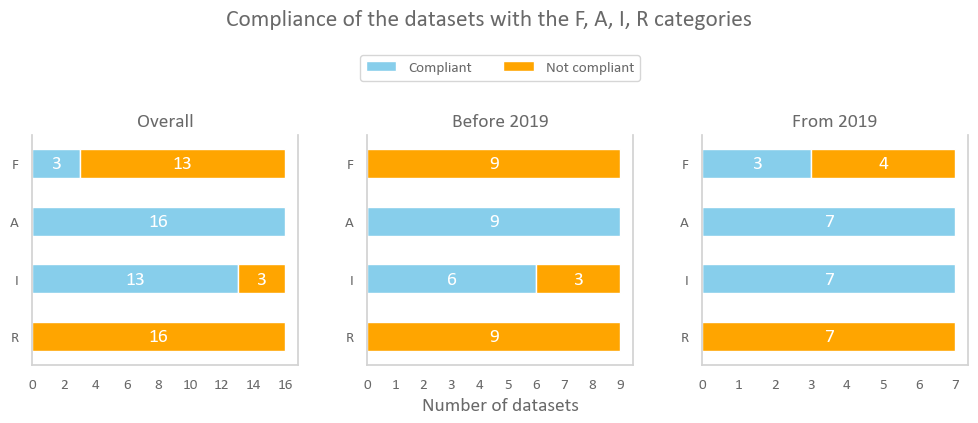

In [13]:
F_principles = [x for x in principle_list if x[0] == "F"]
A_principles = [x for x in principle_list if x[0] == "A"]
I_principles = [x for x in principle_list if x[0] == "I"]
R_principles = [x for x in principle_list if x[0] == "R"]
principle_sets = [F_principles, A_principles, I_principles, R_principles]

fair_column_names = ["F", "A", "I", "R"]
for column in fair_column_names:
    df[column] = np.nan

for index_main in df.index:
    for idx, principle_set in enumerate(principle_sets):
        not_compliant_count = 0
        for principle in principle_set:
            if df.loc[index_main, principle] == "Not compliant":
                not_compliant_count += 1
        if not_compliant_count > 0:
            df.loc[index_main, fair_column_names[idx]] = "Not compliant"
        else:
            df.loc[index_main, fair_column_names[idx]] = "Compliant"

df_pre2019 = df.loc[: idxmax - 1].reset_index(drop=True)
df_from2019 = df.loc[idxmax:].reset_index(drop=True)
df_list = [df, df_pre2019, df_from2019]
title_list = ["Overall", "Before 2019", "From 2019"]
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


for i_num, df_c in enumerate(df_list):
    df_fair_category_compliance = pd.DataFrame(
        index=fair_column_names, columns=["Compliant", "Not compliant"]
    )
    for idx in df_fair_category_compliance.index:
        try:
            compliant_count = df_c[idx].value_counts()["Compliant"]
        except:
            compliant_count = 0
        try:
            non_compliant_count = df_c[idx].value_counts()["Not compliant"]
        except:
            non_compliant_count = 0
        df_fair_category_compliance.loc[idx, "Compliant"] = compliant_count
        df_fair_category_compliance.loc[idx, "Not compliant"] = non_compliant_count

    ax = axs[i_num]
    df_fair_category_compliance.plot(
        ax=ax,
        kind="barh",
        stacked=True,
        color=["skyblue", "orange"],
        title=title_list[i_num],
    )

    ax.invert_yaxis()
    # ax.xaxis.set_ticks(list(range(0, len(df) + 1)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if i_num == 1:
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.38),
            ncol=3,
            fancybox=True,
            shadow=False,
        )
        ax.set_xlabel("Number of datasets")
    else:
        ax.get_legend().remove()

    for c in ax.containers:
        ax.bar_label(
            c, fmt=lambda x: int(x) if x > 0 else "", label_type="center", color="white"
        )
fig.suptitle("Compliance of the datasets with the F, A, I, R categories", y=0.85)
fig.tight_layout()
plt.savefig("output/compliance_fair_categories.png", bbox_inches="tight")
plt.show()

### Compliance with each of the FAIR Principles

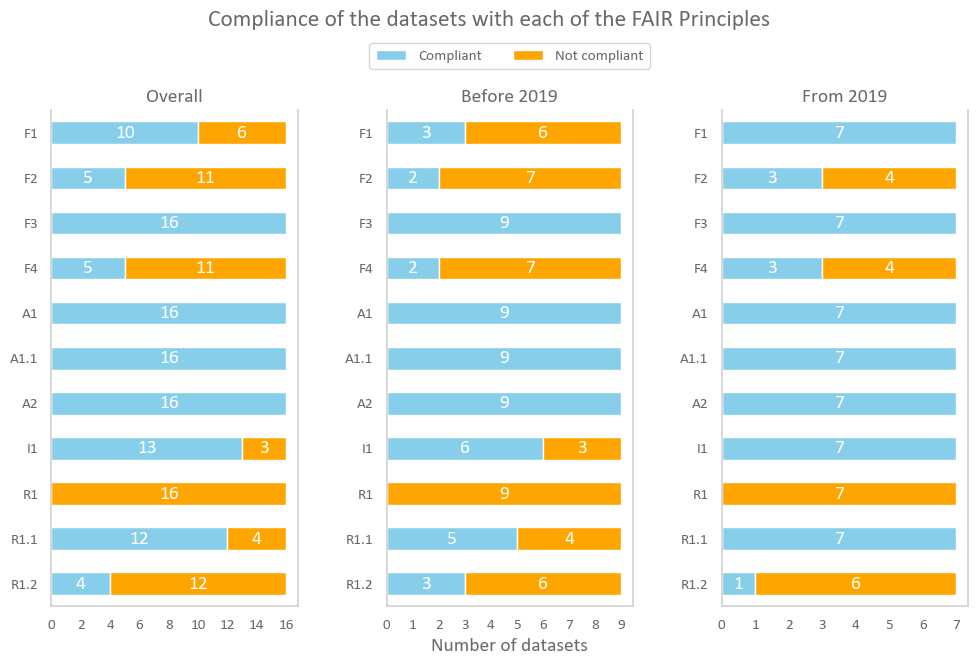

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
for i_num, df_c in enumerate(df_list):
    df_principle_compliance = pd.DataFrame(
        index=principle_list, columns=["Compliant", "Not compliant"]
    )
    for idx in df_principle_compliance.index:
        try:
            compliant_count = df_c[idx].value_counts()["Compliant"]
        except:
            compliant_count = 0
        try:
            non_compliant_count = df_c[idx].value_counts()["Not compliant"]
        except:
            non_compliant_count = 0
        df_principle_compliance.loc[idx, "Compliant"] = compliant_count
        df_principle_compliance.loc[idx, "Not compliant"] = non_compliant_count

    ax = axs[i_num]
    df_principle_compliance.plot(
        ax=ax,
        kind="barh",
        stacked=True,
        color=["skyblue", "orange"],
        title=title_list[i_num],
    )

    ax.invert_yaxis()
    # ax.xaxis.set_ticks(list(range(0, len(df) + 1)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if i_num == 1:
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            fancybox=True,
            shadow=False,
        )
        ax.set_xlabel("Number of datasets")
    else:
        ax.get_legend().remove()

    for c in ax.containers:
        ax.bar_label(
            c, fmt=lambda x: int(x) if x > 0 else "", label_type="center", color="white"
        )
fig.suptitle("Compliance of the datasets with each of the FAIR Principles", y=0.95)
fig.tight_layout()
plt.savefig("output/compliance_each_fair_principles.png", bbox_inches="tight")
plt.show()

### Compliance with individual criteria

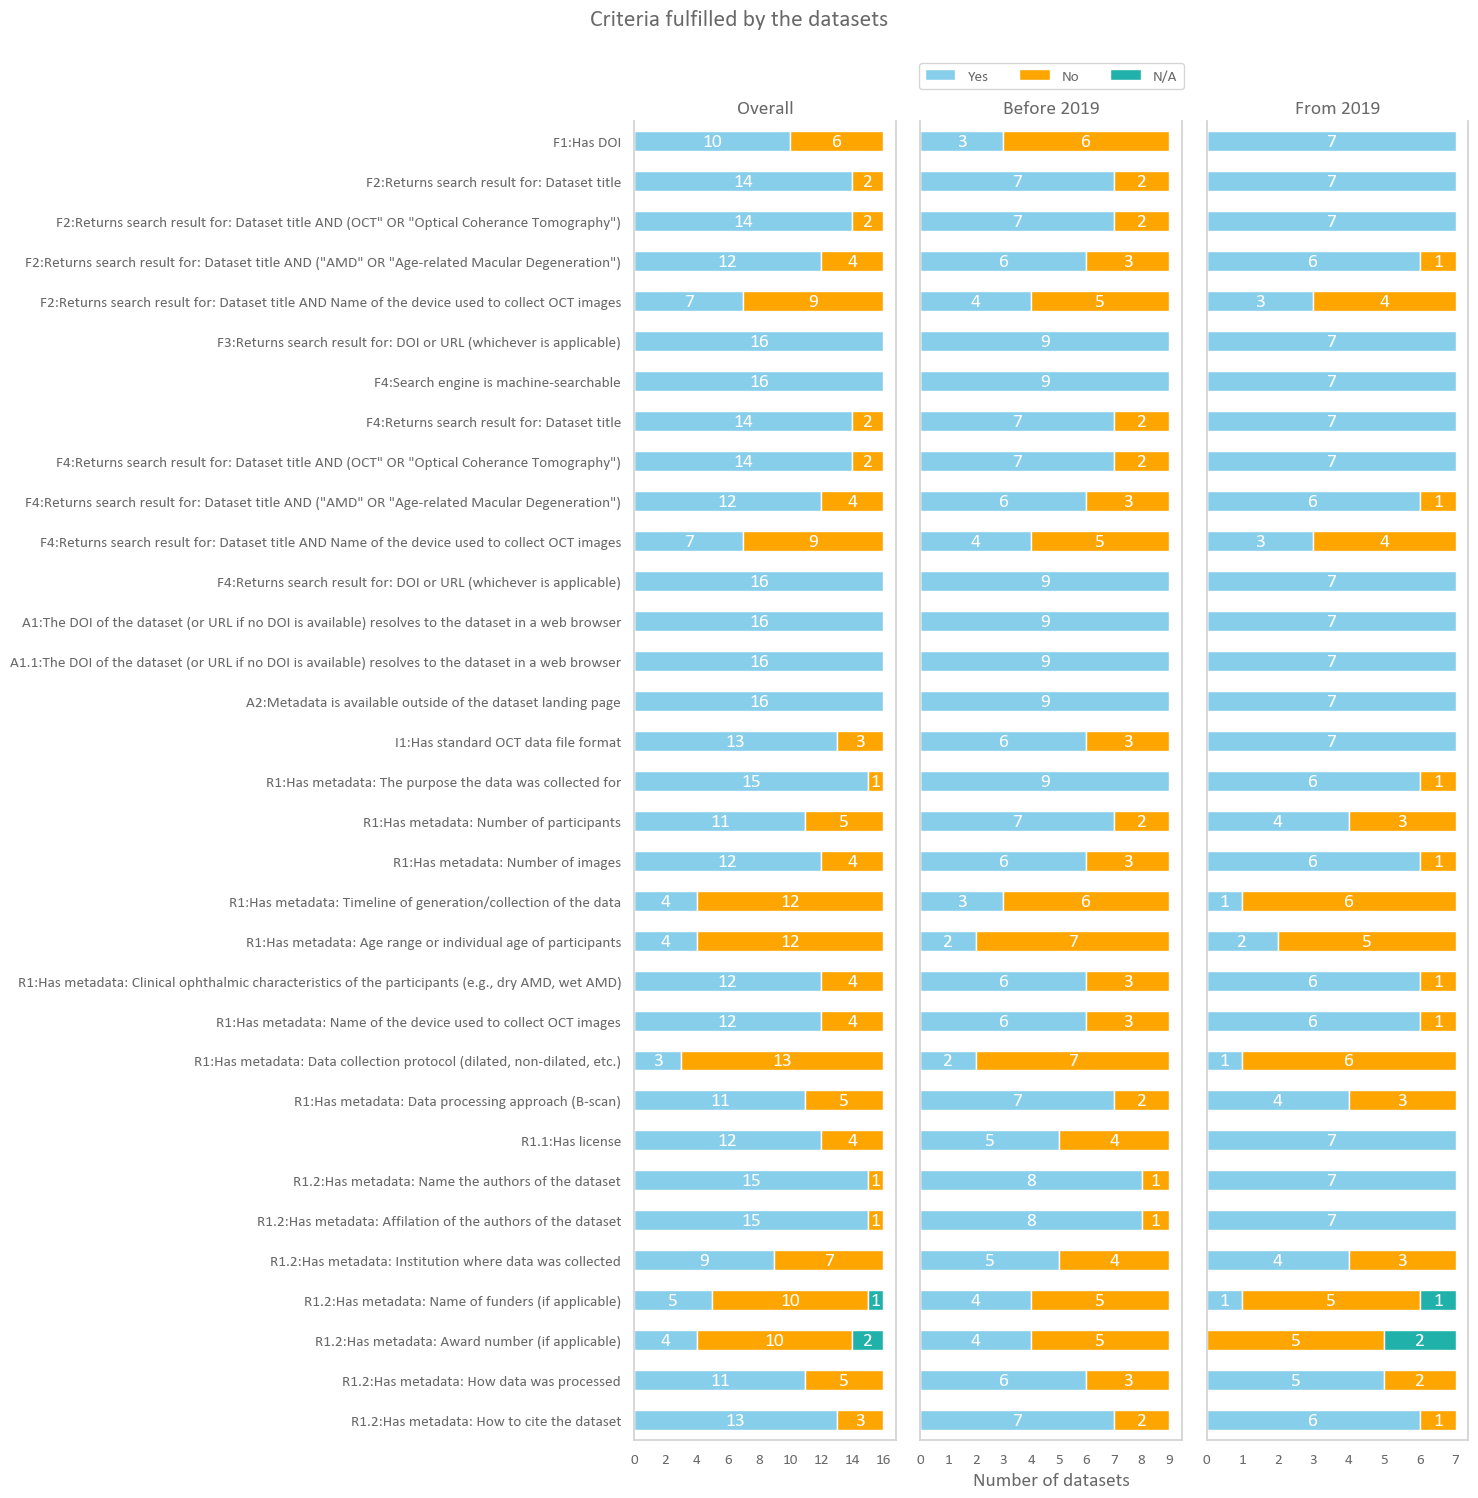

In [15]:
list_criterion_per_principle = []
list_criterion = []
for index in df_compliance_matrix.index:
    principle = df_compliance_matrix.loc[index, "principle"]
    df_principle = df_compliance_matrix.loc[[index]].dropna(axis=1, how="all")
    columns = list(df_principle.columns)
    columns.remove("principle")
    for column in columns:
        list_criterion_per_principle.append(principle + ":" + column)
        list_criterion.append(column)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
for i_num, df_c in enumerate(df_list):
    df_criterion_compliance = pd.DataFrame(
        index=list_criterion_per_principle, columns=["Yes", "No", "N/A"]
    )
    for idx, criterion in enumerate(list_criterion):
        column_values = list(df_c[criterion])
        unique_counts = get_unique_counts(column_values)
        if "yes" in unique_counts:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "Yes"] = (
                unique_counts["yes"]
            )
        else:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "Yes"] = 0
        if "no" in unique_counts:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "No"] = (
                unique_counts["no"]
            )
        else:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "No"] = 0
        if np.nan in unique_counts:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "N/A"] = (
                unique_counts[np.nan]
            )
        else:
            df_criterion_compliance.loc[list_criterion_per_principle[idx], "N/A"] = 0

    ax = axs[i_num]
    df_criterion_compliance.plot(
        ax=ax,
        kind="barh",
        stacked=True,
        color=["skyblue", "orange", "lightseagreen"],
        title=title_list[i_num],
    )

    ax.invert_yaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if i_num == 1 or i_num == 2:
        ax.set_yticks([])

    if i_num == 1:
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=3,
            fancybox=True,
            shadow=False,
        )
        ax.set_xlabel("Number of datasets")
    else:
        ax.get_legend().remove()

    for c in ax.containers:
        ax.bar_label(
            c, fmt=lambda x: int(x) if x > 0 else "", label_type="center", color="white"
        )
fig.suptitle("Criteria fulfilled by the datasets", y=1)
fig.tight_layout()
plt.savefig("output/compliance_criteria.png", bbox_inches="tight")
plt.show()

### License used

In [16]:
column_values = list(df["What license (if applicable)"])
unique_counts = get_unique_counts(column_values)
print("License")
print(unique_counts)

License
{nan: 4, 'Custom terms': 2, 'CC0-1.0': 1, 'CC-BY-4.0': 8, 'CC-BY-ND-4.0': 1}


### File format used

In [17]:
column_values = list(df["Data file format"])
unique_counts = get_unique_counts(column_values)
print("License")
print(unique_counts)

License
{'MAT': 2, 'TIFF': 4, 'PDF': 1, 'JPEG': 6, 'PNG': 3}
